In [1]:
from typing import List
import numpy as np
import cv2
import copy
import os
import matplotlib.pyplot as plt
import skimage
import time
import numpy as np

# PARTE 1 : CALIBRACIÓN

In [201]:
def load_images_from_folder(folder_path: str) -> List:
    # Lista para almacenar las imágenes
    images = []
    
    # Iteramos sobre los archivos de la carpeta
    for filename in os.listdir(folder_path):
        # Comprobamos si el archivo es una imagen (puedes agregar más extensiones si es necesario)
        if filename.endswith(".jpg") or filename.endswith(".png") or filename.endswith(".jpeg"):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)
            if img is not None:  # Verificamos que la imagen se haya cargado correctamente
                images.append(img)
    
    return images

In [203]:
# TODO Build a list containing the paths of all images from the left camera
folder_path = "../data/ChessBoard/"
imgs = load_images_from_folder(folder_path)

### Detecto las esquinas.

In [128]:
# TODO Find corners with cv2.findChessboardCorners()
corners = []
valid_imgs = []  
cont = 0

# Detectar esquinas en las imágenes
for img in imgs:
    corners_img = cv2.findChessboardCorners(img, (7, 7), None)
    if corners_img[0]:  # Si se detectaron esquinas
        corners.append(corners_img)
        valid_imgs.append(img)  # Agregar la imagen válida
    else:
        print(f"No se detectaron esquinas en la imagen {cont}")
    cont += 1

In [129]:
# Hacer una copia de las esquinas detectadas
corners_copy = copy.deepcopy(corners)

# Criterio para refinar las esquinas
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.01)

# Convertir las imágenes válidas a escala de grises
imgs_grey = [cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in valid_imgs]

# Refinar las esquinas detectadas
corners_refined = [
    cv2.cornerSubPix(img_grey, cor[1], (7, 7), (-1, -1), criteria)
    for img_grey, cor in zip(imgs_grey, corners_copy)
]

### Vemos las detecciones.

In [130]:
# Hacer una copia de las imágenes válidas para dibujar las esquinas
imgs_copy = copy.deepcopy(valid_imgs)

# Dibujar las esquinas en las imágenes
for img, cor_refined, cor in zip(imgs_copy, corners_refined, corners):
    cv2.drawChessboardCorners(img, (7, 7), cor_refined, cor[0])

In [131]:
# Mostrar y guardar las imágenes resultantes
def show_image(image, name):
    cv2.imshow(name, image)
    cv2.waitKey(500)
    cv2.destroyAllWindows()

def write_image(output_folder: str, img_name: str, img: np.array):
    if not os.path.exists(output_folder):  
        os.makedirs(output_folder)           
    img_path = os.path.join(output_folder, img_name)  
    cv2.imwrite(img_path, img)  

# Carpeta de salida
output_folder = '../data/corners_detected'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Nombres de archivos para las imágenes resultantes
filenames = [f'imagen_{i+1}.jpg' for i in range(len(imgs_copy))]

# Mostrar y guardar las imágenes
for image, filename in zip(imgs_copy, filenames):
    show_image(image, "Image")
    write_image(output_folder, filename, image)

### Defina y ejecute el método ``get_chessboard_points(chessboard_shape, dx, dy)``

In [132]:
# TODO Design the method. It should return a np.array with np.float32 elements
def get_chessboard_points(chessboard_shape, dx, dy):
    num_columns, num_rows = chessboard_shape
    
    objp = np.zeros((num_rows * num_columns, 3), np.float32)

    objp[:, :2] = np.mgrid[0:num_columns, 0:num_rows].T.reshape(-1, 2) * [dx, dy]

    return objp

In [133]:
# TODO You need the points for every image, not just one
chessboard_points = get_chessboard_points((7, 7), 30, 30)

### Utilice ``cv2.calibrateCamera()`` para obtener los parámetros de calibración para la cámara izquierda

In [134]:
# Filter data and get only those with adequate detections
valid_corners = [cor[1] for cor in corners if cor[0]]
# Convert list to numpy array
valid_corners = np.asarray(valid_corners, dtype=np.float32)

In [135]:
# TODO
objpoints = []  
imgpoints = []  

for corners in valid_corners:
    objpoints.append(chessboard_points)  
    imgpoints.append(corners)   

rms, intrinsics, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(
    objpoints, imgpoints, (320, 240), None, None
)

# Obtain extrinsics
extrinsics = list(map(lambda rvec, tvec: np.hstack((cv2.Rodrigues(rvec)[0], tvec)), rvecs, tvecs))

In [143]:
# Print outputs
print("Intrinsics:\n", intrinsics)
print("Distortion coefficients:\n", dist_coeffs)
print("Root mean squared reprojection error:\n", rms)

Intrinsics:
 [[2.17089681e+03 0.00000000e+00 1.52082974e+02]
 [0.00000000e+00 4.21235834e+03 1.46422261e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion coefficients:
 [[-0.5317102   3.03395891 -0.03161913 -0.03142607 -6.53863547]]
Root mean squared reprojection error:
 1.1762713604858739


### Vemos con cuantas imagenes nos hubiesen bastado para calibrar.

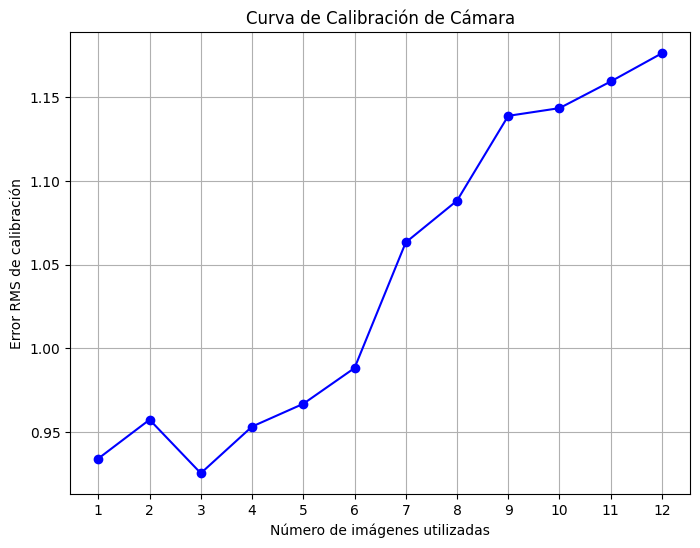

In [137]:
# --- Calibración para la cámara Left ---
errores = []
img_size = imgs_grey[0].shape[::-1]

for i in range(len(objpoints)):
    objpoints_i = objpoints[:i+1]
    corner_i = valid_corners[:i+1]
    
    rms, _, _, _, _ = cv2.calibrateCamera(objpoints_i, corner_i, img_size, None, None)
    
    errores.append(rms)

    
num_imagenes = list(range(1, len(errores) + 1)) 

plt.figure(figsize=(8, 6))
plt.plot(num_imagenes, errores, marker='o', linestyle='-', color='b')

plt.xticks(np.arange(1, len(num_imagenes) + 1, 1))
plt.title("Curva de Calibración de Cámara")
plt.xlabel("Número de imágenes utilizadas")
plt.ylabel("Error RMS de calibración")


plt.grid(True)
plt.show()

# PARTE 2 : DESBLOQUEO SEGURIDAD

In [ ]:
folder_path = "../data/Rubick"
security_images = load_images_from_folder(folder_path)

### Cambie el espacio de color de las imágenes a uno donde la crominancia y la intensidad estén separados (HSV)

In [141]:
# TODO Get a list with ìmgs in HSV color space
hsv_imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2HSV) for img in security_images]

### Aplico las mascaras de colores y los identifico

In [173]:
# Definir rango de colores
light_red = (0, 150, 150)
dark_red = (5, 255, 255)
light_yellow = (26, 100, 100)
dark_yellow = (35, 255, 255)
light_green = (35, 100, 50)
dark_green = (85, 255, 255)

# Crear máscaras para el color
red_masks = [cv2.inRange(img_hsv, light_red, dark_red) for img_hsv in hsv_imgs]
yellow_masks = [cv2.inRange(img_hsv, light_yellow, dark_yellow) for img_hsv in hsv_imgs]
green_masks = [cv2.inRange(img_hsv, light_green, dark_green) for img_hsv in hsv_imgs]

# Combinar máscaras de colores
color_masks = [cv2.bitwise_or(cv2.bitwise_or(red_mask, yellow_mask), green_mask) for red_mask, yellow_mask, green_mask in zip(red_masks, yellow_masks, green_masks)]

# Redimensionar máscaras para que coincidan con las imágenes originales
red_masks_resized = [cv2.resize(mask, (img.shape[1], img.shape[0])) for mask, img in zip(red_masks, security_images)]
yellow_masks_resized = [cv2.resize(mask, (img.shape[1], img.shape[0])) for mask, img in zip(yellow_masks, security_images)]
green_masks_resized = [cv2.resize(mask, (img.shape[1], img.shape[0])) for mask, img in zip(green_masks, security_images)]
color_masks_resized = [cv2.resize(mask, (img.shape[1], img.shape[0])) for mask, img in zip(color_masks, security_images)]

# Aplicar la máscara a las imágenes originales
red_segmented = [cv2.bitwise_and(img, img, mask=mask) for img, mask in zip(security_images, red_masks_resized)]
yellow_segmented = [cv2.bitwise_and(img, img, mask=mask) for img, mask in zip(security_images, yellow_masks_resized)]
green_segmented = [cv2.bitwise_and(img, img, mask=mask) for img, mask in zip(security_images, green_masks_resized)]
colors_segmented = [cv2.bitwise_and(img, img, mask=mask) for img, mask in zip(security_images, color_masks_resized)]

# Mostrar resultados
for i in range(len(hsv_imgs)):
    show_image(security_images[i], "Original Image")
    show_image(red_masks_resized[i], "Red Mask")
    show_image(red_segmented[i], "Red Segmented Image")
    show_image(yellow_masks_resized[i], "Yellow Mask")
    show_image(yellow_segmented[i], "Yellow Segmented Image")
    show_image(green_masks_resized[i], "Green Mask")
    show_image(green_segmented[i], "Green Segmented Image")
    time.sleep(0.5)

# Muestro la combinación de colores
output_folder = "../data/colors_detected"
colors_segmented_img = []
for i in range(len(hsv_imgs)):
    show_image(colors_segmented[i], "Color Segmented Image")
    colors_segmented_img.append(colors_segmented[i])
    write_image(output_folder, "segmented_image" + str(i) + ".jpg", colors_segmented[i])

### Identifico si se han detectado colores

In [ ]:
# Función para verificar si el color ha sido detectado
def is_color_detected(mask):
    # Si hay algún píxel no cero en la máscara, el color ha sido detectado
    # Pongo un threshold de 5 para que el amarillo no detecte un poco de verde
    return cv2.countNonZero(mask) > 5

In [152]:
# Mostrar resultados y verificar si los colores están presentes
for i in range(len(hsv_imgs)):
    print("IMAGEN: " + str(i))
    # Verificamos si cada color está presente en la imagen
    red_detected = is_color_detected(red_masks[i])
    print("Color rojo detectado:", red_detected)
    yellow_detected = is_color_detected(yellow_masks[i])
    print("Color amarillo detectado:", yellow_detected)
    green_detected = is_color_detected(green_masks[i])
    print("Color verde detectado:", green_detected)
    color_detected = is_color_detected(color_masks[i])
    print("Color detectado:", color_detected)

IMAGEN: 0
Color rojo detectado: False
Color amarillo detectado: False
Color verde detectado: True
Color detectado: True
IMAGEN: 1
Color rojo detectado: False
Color amarillo detectado: False
Color verde detectado: False
Color detectado: False
IMAGEN: 2
Color rojo detectado: False
Color amarillo detectado: True
Color verde detectado: False
Color detectado: True
IMAGEN: 3
Color rojo detectado: False
Color amarillo detectado: False
Color verde detectado: False
Color detectado: False
IMAGEN: 4
Color rojo detectado: False
Color amarillo detectado: False
Color verde detectado: False
Color detectado: False
IMAGEN: 5
Color rojo detectado: True
Color amarillo detectado: False
Color verde detectado: False
Color detectado: True


### Para la deteccion de bordes vamos a aplicar el filtro de canny, ya que en la practica 2 vimos que era mas efectivo y robusto que los otros dos filtros vistos en clase

In [196]:
canny_edges_display = []
for i in range(len(security_images)):
    # Imagen a escala de grises
    gray_img = skimage.color.rgb2gray(security_images[i])
    
    # Filtro Canny
    canny_edges = skimage.feature.canny(gray_img)
    canny_edges_display.append((canny_edges * 255).astype(np.uint8))
    show_image(canny_edges_display[i], "Filtro Canny")

#### Para poder ver el patron de un cubo de rubick y que mida correctamente las lineas sin tener en cuenta los huecos, aplicamos operadores morfologicos

In [191]:
# TODO Homework: define the dilation method
def custom_dilate(img: np.array, kernel_size: int = 60) -> np.array:
    # Crear un kernel cuadrado de tamaño kernel_size x kernel_size
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    
    # Aplicar la dilatación utilizando el kernel
    dilated = cv2.dilate(img, kernel, iterations=1)
    
    return dilated

In [197]:
for img in canny_edges_display:
    show_image(img, "Original")
    # Aplica dilatación
    dilated_img = custom_dilate(img)
    show_image(dilated_img, "Dilated")

#### Usamos el filtro para detectar un patron de una cara de un cubo de rubick

In [194]:
# Función para detectar si hay un patrón de cara de un cubo de Rubik
def is_square_detected(canny_edges):
    # Encontramos los contornos en la imagen de bordes
    contours, _ = cv2.findContours(canny_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Iteramos sobre los contornos encontrados
    for contour in contours:
        # Aproximamos el contorno para reducir los puntos
        epsilon = 0.04 * cv2.arcLength(contour, True)  # Tolerancia en la aproximación
        approx = cv2.approxPolyDP(contour, epsilon, True)

        # Verificamos si el contorno tiene 4 puntos
        if len(approx) == 4:
            # Calculamos el área y la relación de aspecto para asegurarnos de que es un cuadrado
            area = cv2.contourArea(approx)
            if area > 1000:  # Aseguramos que el área sea suficientemente grande
                # Comprobamos si el contorno es un cuadrado (todos los ángulos deberían ser 90 grados)
                # Usamos la propiedad de que los ángulos internos de un cuadrado son 90 grados
                (x, y, w, h) = cv2.boundingRect(approx)
                aspect_ratio = w / float(h)

                # Si la relación de aspecto es 1, es un cuadrado
                if 0.9 <= aspect_ratio <= 1.1:
                    return True  # Encontramos un cuadrado

    # Si no encontramos ningún cuadrado
    return False

# Para cada imagen de la lista 'security_images'
for i in range(len(security_images)):
    # Convertimos la imagen a escala de grises
    gray_img = skimage.color.rgb2gray(security_images[i])  # rgb2gray devuelve una imagen de tipo float (0-1)
    gray_img = (gray_img * 255).astype(np.uint8)  # Convertimos de vuelta a uint8 (0-255)
    
    # Aplicamos el filtro Canny para detectar los bordes
    canny_edges = skimage.feature.canny(gray_img / 255.0)  # canny espera valores entre 0 y 1, por eso se divide por 255
    canny_edges_display = (canny_edges * 255).astype(np.uint8)  # Convertimos a imagen visualizable
    
    # Aplico el operador morfologico
    canny_edges_dilated = custom_dilate(canny_edges_display)
    show_image(canny_edges_dilated, "I")
    # Detectamos si se ha encontrado el patrón de una cara de Rubik
    rubiks_detected = is_square_detected(canny_edges_dilated)
    
    # Mostramos el resultado en consola
    print(f"Imagen {i}: Rubik's Face Detected: {rubiks_detected}")
    
    # Mostramos la imagen de los bordes (opcional)
    show_image(canny_edges_display, "Canny Edge Detection")

Imagen 0: Rubik's Face Detected: True
Imagen 1: Rubik's Face Detected: True
Imagen 2: Rubik's Face Detected: True
Imagen 3: Rubik's Face Detected: True
Imagen 4: Rubik's Face Detected: True
Imagen 5: Rubik's Face Detected: True


#### Comprobamos que, por ejemplo, no detectaria el tablero de ajedrez como cubo de rubick

In [195]:
# Para cada imagen de la lista 'security_images'
for i in range(len(imgs)):
    # Convertimos la imagen a escala de grises
    gray_img = skimage.color.rgb2gray(imgs[i])  # rgb2gray devuelve una imagen de tipo float (0-1)
    gray_img = (gray_img * 255).astype(np.uint8)  # Convertimos de vuelta a uint8 (0-255)
    
    # Aplicamos el filtro Canny para detectar los bordes
    canny_edges = skimage.feature.canny(gray_img / 255.0)  # canny espera valores entre 0 y 1, por eso se divide por 255
    canny_edges_display = (canny_edges * 255).astype(np.uint8)  # Convertimos a imagen visualizable
    
    # Aplico el operador morfologico
    canny_edges_dilated = custom_dilate(canny_edges_display)
    show_image(canny_edges_dilated, "I")
    # Detectamos si se ha encontrado el patrón de una cara de Rubik
    rubiks_detected = is_square_detected(canny_edges_dilated)
    
    # Mostramos el resultado en consola
    print(f"Imagen {i}: Rubik's Face Detected: {rubiks_detected}")
    
    # Mostramos la imagen de los bordes (opcional)
    show_image(canny_edges_display, "Canny Edge Detection")

Imagen 0: Rubik's Face Detected: False
Imagen 1: Rubik's Face Detected: False
Imagen 2: Rubik's Face Detected: False
Imagen 3: Rubik's Face Detected: True
Imagen 4: Rubik's Face Detected: False
Imagen 5: Rubik's Face Detected: False
Imagen 6: Rubik's Face Detected: True
Imagen 7: Rubik's Face Detected: True
Imagen 8: Rubik's Face Detected: False
Imagen 9: Rubik's Face Detected: False
Imagen 10: Rubik's Face Detected: False
Imagen 11: Rubik's Face Detected: False


### Ahora juntamos todo, para que comprueba primero si lo que se ha detectado es un cubo de rubick, y si la imagen contiene un cubo de rubick, entonces comprueba los colores si esta entre los seleccionados.

In [220]:
import cv2
import numpy as np
import skimage.feature
import skimage.color
from typing import List
import random

# Cargar imágenes desde una carpeta
def load_images_from_folder(folder_path: str) -> List:
    # Lista para almacenar las imágenes
    images = []
    
    # Iteramos sobre los archivos de la carpeta
    for filename in os.listdir(folder_path):
        # Comprobamos si el archivo es una imagen (puedes agregar más extensiones si es necesario)
        if filename.endswith(".jpg") or filename.endswith(".png") or filename.endswith(".jpeg"):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)
            if img is not None:  # Verificamos que la imagen se haya cargado correctamente
                images.append(img)
    
    return images

# Cargar imágenes
folder_path = "../data/Mixture_Images"
output_folder = "../data/security_passed"

# Cargar todas las imágenes desde la carpeta y las mezclo entre sí
security_images = load_images_from_folder(folder_path)
random.shuffle(security_images)

# Convertir las imágenes a espacio de color HSV
hsv_imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2HSV) for img in security_images]

# Definir rango de colores
light_red = (0, 150, 150)
dark_red = (5, 255, 255)
light_yellow = (26, 100, 100)
dark_yellow = (35, 255, 255)
light_green = (35, 100, 50)
dark_green = (85, 255, 255)

# Crear máscaras para el color
red_masks = [cv2.inRange(img_hsv, light_red, dark_red) for img_hsv in hsv_imgs]
yellow_masks = [cv2.inRange(img_hsv, light_yellow, dark_yellow) for img_hsv in hsv_imgs]
green_masks = [cv2.inRange(img_hsv, light_green, dark_green) for img_hsv in hsv_imgs]

# Combinar máscaras de colores
color_masks = [cv2.bitwise_or(cv2.bitwise_or(red_mask, yellow_mask), green_mask) for red_mask, yellow_mask, green_mask in zip(red_masks, yellow_masks, green_masks)]

# Redimensionar máscaras para que coincidan con las imágenes originales
red_masks_resized = [cv2.resize(mask, (img.shape[1], img.shape[0])) for mask, img in zip(red_masks, security_images)]
yellow_masks_resized = [cv2.resize(mask, (img.shape[1], img.shape[0])) for mask, img in zip(yellow_masks, security_images)]
green_masks_resized = [cv2.resize(mask, (img.shape[1], img.shape[0])) for mask, img in zip(green_masks, security_images)]
color_masks_resized = [cv2.resize(mask, (img.shape[1], img.shape[0])) for mask, img in zip(color_masks, security_images)]

# Aplicar la máscara a las imágenes originales
red_segmented = [cv2.bitwise_and(img, img, mask=mask) for img, mask in zip(security_images, red_masks_resized)]
yellow_segmented = [cv2.bitwise_and(img, img, mask=mask) for img, mask in zip(security_images, yellow_masks_resized)]
green_segmented = [cv2.bitwise_and(img, img, mask=mask) for img, mask in zip(security_images, green_masks_resized)]
colors_segmented = [cv2.bitwise_and(img, img, mask=mask) for img, mask in zip(security_images, color_masks_resized)]

# Función para verificar si el color ha sido detectado
def is_color_detected(mask):
    return cv2.countNonZero(mask) > 5  # Verifica si hay píxeles no nulos

# Función para dilatar la imagen
def custom_dilate(img: np.array, kernel_size: int = 60) -> np.array:
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    dilated = cv2.dilate(img, kernel, iterations=1)
    return dilated

# Función para detectar si es un cuadrado (cara de un cubo de Rubik)
def is_square_detected(canny_edges):
    contours, _ = cv2.findContours(canny_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        epsilon = 0.04 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        if len(approx) == 4:
            area = cv2.contourArea(approx)
            if area > 1000:
                (x, y, w, h) = cv2.boundingRect(approx)
                aspect_ratio = w / float(h)
                if 0.9 <= aspect_ratio <= 1.1:
                    return True
    return False

# Procesar cada imagen
for i in range(len(security_images)):
    # Convertimos la imagen a escala de grises
    gray_img = skimage.color.rgb2gray(security_images[i])
    gray_img = (gray_img * 255).astype(np.uint8)  # Convertimos a uint8
    
    # Aplicamos el filtro Canny
    canny_edges = skimage.feature.canny(gray_img / 255.0)
    canny_edges_display = (canny_edges * 255).astype(np.uint8)
    
    # Aplico dilatación a los bordes detectados
    canny_edges_dilated = custom_dilate(canny_edges_display)

    # Detectamos si se ha encontrado el patrón de una cara de Rubik
    rubiks_detected = is_square_detected(canny_edges_dilated)
    
    # Mostramos el resultado en consola
    print(f"Imagen {i}: Rubik's Face Detected: {rubiks_detected}")

    # Si detectamos un cubo de Rubik, verificamos los colores
    if rubiks_detected:
        print(f"Imagen {i}: Comprobando colores...")

        # Verificar si los colores están presentes
        red_detected = is_color_detected(red_masks[i])
        yellow_detected = is_color_detected(yellow_masks[i])
        green_detected = is_color_detected(green_masks[i])
        color_detected = is_color_detected(color_masks[i])

        print("Color rojo detectado:", red_detected)
        print("Color amarillo detectado:", yellow_detected)
        print("Color verde detectado:", green_detected)
        print("Color detectado:", color_detected)
        # Guardo las imagenes que han pasado la seguridad
        if color_detected:
            write_image(output_folder, "security_passed" + str(i) + ".jpg", security_images[i])
    
    # Mostrar la imagen original 
    show_image(security_images[i], "Original Image")
    
    # Mostrar la imagen de los bordes 
    show_image(canny_edges_display, "Canny Edge Detection")
    
    # Mostrar la imagen con el operador morfologico
    show_image(canny_edges_dilated, "Canny Edge Dilated")

    # Si deseas mostrar la imagen segmentada por colores
    if rubiks_detected:
        show_image(colors_segmented[i], "Color Segmented Image")
    print("------------------------------------")
    time.sleep(1)

Imagen 0: Rubik's Face Detected: False
------------------------------------
Imagen 1: Rubik's Face Detected: False
------------------------------------
Imagen 2: Rubik's Face Detected: False
------------------------------------
Imagen 3: Rubik's Face Detected: True
Imagen 3: Comprobando colores...
Color rojo detectado: False
Color amarillo detectado: False
Color verde detectado: False
Color detectado: False
------------------------------------
Imagen 4: Rubik's Face Detected: True
Imagen 4: Comprobando colores...
Color rojo detectado: False
Color amarillo detectado: False
Color verde detectado: False
Color detectado: False
------------------------------------
Imagen 5: Rubik's Face Detected: True
Imagen 5: Comprobando colores...
Color rojo detectado: True
Color amarillo detectado: False
Color verde detectado: False
Color detectado: True
------------------------------------
Imagen 6: Rubik's Face Detected: True
Imagen 6: Comprobando colores...
Color rojo detectado: False
Color amarillo 

## Comprobación en tiempo real

In [ ]:
import cv2
import numpy as np
import skimage.feature
import skimage.color

# Función para detectar si el color está presente en la imagen
def is_color_detected(mask):
    return cv2.countNonZero(mask) > 5  # Verifica si hay píxeles no nulos

# Función para dilatar la imagen
def custom_dilate(img: np.array, kernel_size: int = 60) -> np.array:
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    dilated = cv2.dilate(img, kernel, iterations=1)
    return dilated

# Función para detectar si es un cuadrado (cara de un cubo de Rubik)
def is_square_detected(canny_edges):
    contours, _ = cv2.findContours(canny_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        epsilon = 0.04 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        if len(approx) == 4:
            area = cv2.contourArea(approx)
            if area > 1000:
                (x, y, w, h) = cv2.boundingRect(approx)
                aspect_ratio = w / float(h)
                if 0.9 <= aspect_ratio <= 1.1:
                    return True
    return False

# Definir rango de colores
light_red = (0, 150, 150)
dark_red = (5, 255, 255)
light_yellow = (26, 100, 100)
dark_yellow = (35, 255, 255)
light_green = (35, 100, 50)
dark_green = (85, 255, 255)

# Configuración de la cámara
cap = cv2.VideoCapture(0)  # Abre la cámara web

# Verificar si la cámara está abierta
if not cap.isOpened():
    print("No se pudo abrir la cámara.")
    exit()

# Procesar cada fotograma del video
while True:
    # Capturar el fotograma del video
    ret, frame = cap.read()
    
    if not ret:
        print("No se pudo obtener el fotograma.")
        break

    # Convertir la imagen a espacio de color HSV
    hsv_img = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Crear máscaras para los colores
    red_mask = cv2.inRange(hsv_img, light_red, dark_red)
    yellow_mask = cv2.inRange(hsv_img, light_yellow, dark_yellow)
    green_mask = cv2.inRange(hsv_img, light_green, dark_green)
    
    # Combinar las máscaras de colores
    color_mask = cv2.bitwise_or(cv2.bitwise_or(red_mask, yellow_mask), green_mask)
    
    # Dilatar las máscaras
    red_mask_resized = cv2.resize(red_mask, (frame.shape[1], frame.shape[0]))
    yellow_mask_resized = cv2.resize(yellow_mask, (frame.shape[1], frame.shape[0]))
    green_mask_resized = cv2.resize(green_mask, (frame.shape[1], frame.shape[0]))
    color_mask_resized = cv2.resize(color_mask, (frame.shape[1], frame.shape[0]))

    # Aplicar la máscara a la imagen original
    red_segmented = cv2.bitwise_and(frame, frame, mask=red_mask_resized)
    yellow_segmented = cv2.bitwise_and(frame, frame, mask=yellow_mask_resized)
    green_segmented = cv2.bitwise_and(frame, frame, mask=green_mask_resized)
    color_segmented = cv2.bitwise_and(frame, frame, mask=color_mask_resized)

    # Convertir a escala de grises
    gray_img = skimage.color.rgb2gray(frame)
    gray_img = (gray_img * 255).astype(np.uint8)  # Convertir a uint8
    
    # Aplicar el filtro Canny
    canny_edges = skimage.feature.canny(gray_img / 255.0)
    canny_edges_display = (canny_edges * 255).astype(np.uint8)
    
    # Aplico dilatación a los bordes detectados
    canny_edges_dilated = custom_dilate(canny_edges_display)
    
    # Detectar si se ha encontrado el patrón de una cara de Rubik
    rubiks_detected = is_square_detected(canny_edges_dilated)
    
    # Mostrar el resultado en consola
    print(f"Rubik's Face Detected: {rubiks_detected}")
    
    if rubiks_detected:
        print("Comprobando colores...")

        # Verificar si los colores están presentes
        red_detected = is_color_detected(red_mask)
        yellow_detected = is_color_detected(yellow_mask)
        green_detected = is_color_detected(green_mask)
        color_detected = is_color_detected(color_mask)

        print("Color rojo detectado:", red_detected)
        print("Color amarillo detectado:", yellow_detected)
        print("Color verde detectado:", green_detected)
        print("Color detectado:", color_detected)

    # Mostrar las imágenes en tiempo real
    cv2.imshow("Original Image", frame)
    cv2.imshow("Canny Edge Detection", canny_edges_display)
    cv2.imshow("Canny Edge Dilated", canny_edges_dilated)

    if rubiks_detected:
        cv2.imshow("Color Segmented Image", color_segmented)
    
    # Si presionas 'q', se detendrá el video
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Liberar la cámara y cerrar todas las ventanas
cap.release()
cv2.destroyAllWindows()

Añado los frames en la pantalla

In [ ]:
# Función para detectar si el color está presente en la imagen
def is_color_detected(mask):
    return cv2.countNonZero(mask) > 5  # Verifica si hay píxeles no nulos

# Función para dilatar la imagen
def custom_dilate(img: np.array, kernel_size: int = 60) -> np.array:
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    dilated = cv2.dilate(img, kernel, iterations=1)
    return dilated

# Función para detectar si es un cuadrado (cara de un cubo de Rubik)
def is_square_detected(canny_edges):
    contours, _ = cv2.findContours(canny_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        epsilon = 0.04 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        if len(approx) == 4:
            area = cv2.contourArea(approx)
            if area > 1000:
                (x, y, w, h) = cv2.boundingRect(approx)
                aspect_ratio = w / float(h)
                if 0.9 <= aspect_ratio <= 1.1:
                    return True
    return False

# Definir rango de colores
light_red = (0, 150, 150)
dark_red = (5, 255, 255)
light_yellow = (26, 100, 100)
dark_yellow = (35, 255, 255)
light_green = (35, 100, 50)
dark_green = (85, 255, 255)

# Configuración de la cámara
cap = cv2.VideoCapture(0)  # Abre la cámara web

# Verificar si la cámara está abierta
if not cap.isOpened():
    print("No se pudo abrir la cámara.")
    exit()

# Variables para calcular FPS
fps = 0
prev_time = time.time()

# Procesar cada fotograma del video
while True:
    # Capturar el fotograma del video
    ret, frame = cap.read()
    
    if not ret:
        print("No se pudo obtener el fotograma.")
        break

    # Calcular FPS
    current_time = time.time()
    fps = 1 / (current_time - prev_time)
    prev_time = current_time

    # Convertir la imagen a espacio de color HSV
    hsv_img = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Crear máscaras para los colores
    red_mask = cv2.inRange(hsv_img, light_red, dark_red)
    yellow_mask = cv2.inRange(hsv_img, light_yellow, dark_yellow)
    green_mask = cv2.inRange(hsv_img, light_green, dark_green)
    
    # Combinar las máscaras de colores
    color_mask = cv2.bitwise_or(cv2.bitwise_or(red_mask, yellow_mask), green_mask)
    
    # Dilatar las máscaras
    red_mask_resized = cv2.resize(red_mask, (frame.shape[1], frame.shape[0]))
    yellow_mask_resized = cv2.resize(yellow_mask, (frame.shape[1], frame.shape[0]))
    green_mask_resized = cv2.resize(green_mask, (frame.shape[1], frame.shape[0]))
    color_mask_resized = cv2.resize(color_mask, (frame.shape[1], frame.shape[0]))

    # Aplicar la máscara a la imagen original
    red_segmented = cv2.bitwise_and(frame, frame, mask=red_mask_resized)
    yellow_segmented = cv2.bitwise_and(frame, frame, mask=yellow_mask_resized)
    green_segmented = cv2.bitwise_and(frame, frame, mask=green_mask_resized)
    color_segmented = cv2.bitwise_and(frame, frame, mask=color_mask_resized)

    # Convertir a escala de grises
    gray_img = skimage.color.rgb2gray(frame)
    gray_img = (gray_img * 255).astype(np.uint8)  # Convertir a uint8
    
    # Aplicar el filtro Canny
    canny_edges = skimage.feature.canny(gray_img / 255.0)
    canny_edges_display = (canny_edges * 255).astype(np.uint8)
    
    # Aplico dilatación a los bordes detectados
    canny_edges_dilated = custom_dilate(canny_edges_display)
    
    # Detectar si se ha encontrado el patrón de una cara de Rubik
    rubiks_detected = is_square_detected(canny_edges_dilated)
    
    # Mostrar el resultado en consola
    print(f"Rubik's Face Detected: {rubiks_detected}")
    
    if rubiks_detected:
        print("Comprobando colores...")

        # Verificar si los colores están presentes
        red_detected = is_color_detected(red_mask)
        yellow_detected = is_color_detected(yellow_mask)
        green_detected = is_color_detected(green_mask)
        color_detected = is_color_detected(color_mask)

        print("Color rojo detectado:", red_detected)
        print("Color amarillo detectado:", yellow_detected)
        print("Color verde detectado:", green_detected)
        print("Color detectado:", color_detected)

    # Mostrar las imágenes en tiempo real
    cv2.putText(frame, f"FPS: {fps:.2f}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.imshow("Original Image", frame)
    cv2.imshow("Canny Edge Detection", canny_edges_display)
    cv2.imshow("Canny Edge Dilated", canny_edges_dilated)

    if rubiks_detected:
        cv2.imshow("Color Segmented Image", color_segmented)
    
    # Si presionas 'q', se detendrá el video
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Liberar la cámara y cerrar todas las ventanas
cap.release()
cv2.destroyAllWindows()


Añado el sistema de seguridad -> se tienen que meter los colores en orden

In [8]:
import cv2
import numpy as np
import skimage.feature
import skimage.color
import time

# Función para detectar si el color está presente en la imagen
def is_color_detected(mask):
    return cv2.countNonZero(mask) > 5  # Verifica si hay píxeles no nulos

# Función para dilatar la imagen
def custom_dilate(img: np.array, kernel_size: int = 60) -> np.array:
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    dilated = cv2.dilate(img, kernel, iterations=1)
    return dilated

# Función para detectar si es un cuadrado (cara de un cubo de Rubik)
def is_square_detected(canny_edges):
    contours, _ = cv2.findContours(canny_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        epsilon = 0.04 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        if len(approx) == 4:
            area = cv2.contourArea(approx)
            if area > 1000:
                (x, y, w, h) = cv2.boundingRect(approx)
                aspect_ratio = w / float(h)
                if 0.9 <= aspect_ratio <= 1.1:
                    return True
    return False 

# Definir rango de colores
light_red = (0, 150, 150)
dark_red = (5, 255, 255)
light_yellow = (26, 100, 100)
dark_yellow = (35, 255, 255)
light_green = (35, 100, 50)
dark_green = (85, 255, 255)

# Configuración de la cámara
cap = cv2.VideoCapture(0)  # Abre la cámara web

# Verificar si la cámara está abierta
if not cap.isOpened():
    print("No se pudo abrir la cámara.")
    exit()

# Estados del sistema de seguridad
security_state = 0  # 0 = espera rojo, 1 = espera amarillo, 2 = espera verde

# Variables para calcular FPS
fps = 0
prev_time = time.time()

# Procesar cada fotograma del video
while True:
    # Capturar el fotograma del video
    ret, frame = cap.read()
    
    if not ret:
        print("No se pudo obtener el fotograma.")
        break

    # Calcular FPS
    current_time = time.time()
    fps = 1 / (current_time - prev_time)
    prev_time = current_time

    # Convertir la imagen a espacio de color HSV
    hsv_img = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Crear máscaras para los colores
    red_mask = cv2.inRange(hsv_img, light_red, dark_red)
    yellow_mask = cv2.inRange(hsv_img, light_yellow, dark_yellow)
    green_mask = cv2.inRange(hsv_img, light_green, dark_green)
    
    # Combinar las máscaras de colores
    color_mask = cv2.bitwise_or(cv2.bitwise_or(red_mask, yellow_mask), green_mask)
    
    # Convertir a escala de grises
    gray_img = skimage.color.rgb2gray(frame)
    gray_img = (gray_img * 255).astype(np.uint8)  # Convertir a uint8
    
    # Aplicar el filtro Canny
    canny_edges = skimage.feature.canny(gray_img / 255.0)
    canny_edges_display = (canny_edges * 255).astype(np.uint8)
    
    # Aplico dilatación a los bordes detectados
    canny_edges_dilated = custom_dilate(canny_edges_display)
    
    # Detectar si se ha encontrado el patrón de una cara de Rubik
    rubiks_detected = is_square_detected(canny_edges_dilated)

    if rubiks_detected:
        #print(f"Rubik's Face Detected: {rubiks_detected}")
        red_detected = is_color_detected(red_mask)
        yellow_detected = is_color_detected(yellow_mask)
        green_detected = is_color_detected(green_mask)

        if security_state == 0 and red_detected:
            print("Paso 1: Color rojo detectado.")
            security_state = 1
            time.sleep(5)
        elif security_state == 1 and yellow_detected:
            print("Paso 2: Color amarillo detectado.")
            security_state = 2
            time.sleep(5)
        elif security_state == 2 and green_detected:
            print("Paso 3: Color verde detectado. Sistema desbloqueado.")
            break
        elif red_detected or yellow_detected or green_detected:
            print("Secuencia incorrecta. Reiniciando sistema.")
            security_state = 0  # Reiniciar si los colores están fuera de orden
    else:
        pass
        #print("No se detecta un cubo de Rubik.")

    # Mostrar las imágenes en tiempo real con FPS
    cv2.putText(frame, f"FPS: {fps:.2f}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.imshow("Original Image", frame)
    cv2.imshow("Canny Edge Detection", canny_edges_display)
    cv2.imshow("Canny Edge Dilated", canny_edges_dilated)

    # Si presionas 'q', se detendrá el video
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Liberar la cámara y cerrar todas las ventanas
cap.release()
cv2.destroyAllWindows()


Paso 1: Color rojo detectado.
Paso 2: Color amarillo detectado.
Paso 3: Color verde detectado. Sistema desbloqueado.


# Tracker en tiempo Real

In [3]:
import cv2
import os

Probamos el tracker sobre diferentes videos de pasos de cebra, donde tenemos que seleccionar las personas manualmente a seguir.

In [3]:
# Load the video
video_path = "../videos/real_pedestrian.mp4"
output_path = "../data/TrackerVideos/tracked_video1.avi"

cap = cv2.VideoCapture(video_path)

# Check if the video is loaded
if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

# Read the first frame
ret, frame = cap.read()
if not ret:
    print("Error: Could not read the video frame.")
    exit()

# Get the video's width, height, and FPS
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

# Scale factor (adjust this to resize as needed)
scale_factor = 0.5
resized_width = int(frame_width * scale_factor)
resized_height = int(frame_height * scale_factor)

# Resize the first frame for ROI selection
frame_resized = cv2.resize(frame, (resized_width, resized_height))

# Create a window with the resized dimensions
cv2.namedWindow("Select Object to Track", cv2.WINDOW_NORMAL)
cv2.resizeWindow("Select Object to Track", resized_width, resized_height)

# Select ROI on the resized frame
bbox = cv2.selectROI("Select Object to Track", frame_resized, fromCenter=False, showCrosshair=True)
cv2.destroyWindow("Select Object to Track")

# Scale the bounding box back to the resized dimensions
bbox = tuple(int(coord) for coord in bbox)

# Initialize the tracker with the first frame and bounding box
tracker = cv2.TrackerCSRT_create()
tracker.init(frame_resized, bbox)

# Initialize the VideoWriter
fourcc = cv2.VideoWriter_fourcc(*'XVID')  # Codec for AVI format
# out = cv2.VideoWriter(output_path, fourcc, fps, (resized_width, resized_height))

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Resize the frame to match the scaled dimensions
    frame_resized = cv2.resize(frame, (resized_width, resized_height))

    # Update the tracker
    success, bbox = tracker.update(frame_resized)

    if success:
        # Draw the bounding box if tracking is successful
        x, y, w, h = map(int, bbox)
        cv2.rectangle(frame_resized, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(frame_resized, "Tracking", (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    else:
        # Display 'Lost' if tracking fails
        cv2.putText(frame_resized, "Lost", (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

    # Write the processed frame to the output video
    # out.write(frame_resized)

    # Display the result
    cv2.imshow("Tracking", frame_resized)

    # Exit on pressing 'q'
    if cv2.waitKey(5) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
# out.release()
cv2.destroyAllWindows()

print(f"Processed video saved at: {output_path}")


Processed video saved at: ../data/TrackerVideos/tracked_video1.avi


Automatizamos el proceso de seleccion de las personas a seguir.

In [3]:
import cv2
import time

# Load the video
video_path = "../videos/real_pedestrian.mp4"
output_path = "../data/TrackerVideos/autotracked_video1.avi"

cap = cv2.VideoCapture(video_path)

# Check if the video is loaded
if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

# Get the video's width, height, and FPS
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

# Scale factor (adjust this to resize as needed)
scale_factor = 0.5
resized_width = int(frame_width * scale_factor)
resized_height = int(frame_height * scale_factor)

# Load the HOG + SVM pedestrian detector from OpenCV
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

# Initialize tracker (use any tracker you prefer)
tracker = cv2.TrackerCSRT_create()

# Read the first frame
ret, frame = cap.read()
if not ret:
    print("Error: Could not read the video frame.")
    exit()

# Resize the first frame for better performance and ROI selection
frame_resized = cv2.resize(frame, (resized_width, resized_height))

# Detect pedestrians in the first frame
boxes, weights = hog.detectMultiScale(frame_resized, winStride=(8, 8), padding=(4, 4), scale=1.05)

# If at least one pedestrian is detected, initialize the tracker with the first detected pedestrian
if len(boxes) > 0:
    # Select the first detected pedestrian
    bbox = boxes[0]
    x, y, w, h = bbox
    # Initialize the tracker with the detected bounding box
    tracker.init(frame_resized, bbox)
    print(f"Pedestrian detected at: {bbox}")
else:
    print("No pedestrian detected in the first frame.")
    exit()

# Initialize the VideoWriter with resized dimensions
fourcc = cv2.VideoWriter_fourcc(*'XVID')  # Codec for AVI format
out = cv2.VideoWriter(output_path, fourcc, fps, (resized_width, resized_height))

# Variables for calculating FPS
fps_display = 0
prev_time = time.time()

# Start tracking the pedestrian
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Calculate FPS
    current_time = time.time()
    time_difference = current_time - prev_time
    if time_difference > 0:
        fps_display = 1 / time_difference
    prev_time = current_time

    # Resize the frame to match the scaled dimensions for faster processing
    frame_resized = cv2.resize(frame, (resized_width, resized_height))

    # Update the tracker
    success, bbox = tracker.update(frame_resized)

    if success:
        # Draw the bounding box if tracking is successful
        x, y, w, h = map(int, bbox)
        cv2.rectangle(frame_resized, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(frame_resized, "Tracking", (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    else:
        # Display 'Lost' if tracking fails
        cv2.putText(frame_resized, "Lost", (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

    # Display FPS on the frame
    cv2.putText(frame_resized, f"FPS: {fps_display:.2f}", (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)

    # Write the processed frame with the tracking box to the output video
    out.write(frame_resized)

    # Display the result
    cv2.imshow("Tracking", frame_resized)

    # Exit on pressing 'q'
    if cv2.waitKey(5) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
out.release()
cv2.destroyAllWindows()

print(f"Processed video saved at: {output_path}")

Pedestrian detected at: [562 188  78 160]
Processed video saved at: ../data/TrackerVideos/autotracked_video1.avi
